In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler

Prepare data

In [55]:
db = sqlite3.connect("BaseballStats.db")

In [56]:
HITTER_STATS_COLS = 24 # All columns but mlbId/year
PITCHER_STATS_COLS = 13
PLAYER_COLS = 2 # Age at signing, draft pick
HITTER_COLS = HITTER_STATS_COLS + PLAYER_COLS
PITCHER_COLS = PITCHER_STATS_COLS + PLAYER_COLS

HITTER_OUTPUT_COLS = 6
HITTER_OUTPUT_COLS = 1

In [57]:
D_TYPE = torch.float32

In [58]:
levelMap = {1:0,11:1,12:2,13:3,14:4,15:5,16:6,17:7}

In [59]:
cursor = db.cursor()
hitters = cursor.execute('''
                         SELECT mp.mlbId, mp.ageAtSigningYear, p.draftPick
                         FROM Model_Players AS mp
                         INNER JOIN Player as p ON mp.mlbId = p.mlbId
                         WHERE mp.isHitter='1'
                         ''').fetchall()

pitchers = cursor.execute('''
                         SELECT mp.mlbId, mp.ageAtSigningYear, p.draftPick
                         FROM Model_Players AS mp
                         INNER JOIN Player as p ON mp.mlbId = p.mlbId
                         WHERE mp.isPitcher='1'
                         ''').fetchall()

Get the mean/std dev of columns to do input normalization

In [60]:
hitterDf = pd.read_sql_query('''
                             SELECT Month, Age, PA, Level, 
                             ParkRunFactor, ParkHRFactor, avgRatio, obpRatio,
                             isoRatio, wOBARatio, sbRateRatio, sbPercRatio,
                             hrPercRatio, bbPercRatio, kPercRatio,
                             PercC, Perc1B, Perc2B, Perc3B, PercSS, PercLF, PercCF, PercRF, PercDH
                             FROM Model_HitterStats''', db)

means = hitterDf.mean().tolist()
stds = hitterDf.std().tolist()

In [61]:
def GetNormalizedInput(idx, value):
    value -= means[idx]
    return value / stds[idx]

Get the mean/std for starting age and draft pick

In [62]:
ages = []
picks = []

for _, signingAge, draftPick in tqdm(hitters):
    ages.append(signingAge)
    if draftPick == None:
        picks.append(-100)
    else:
        picks.append(draftPick)
    
ageMean = torch.tensor(ages).float().mean()
ageStd = torch.tensor(ages).float().std()
pickMean = torch.tensor(picks).float().mean()
pickStd = torch.tensor(picks).float().std()

100%|██████████| 9502/9502 [00:00<00:00, 4753044.32it/s]


Load Data

In [63]:
hitterInput = []
pitcherInput = []
hitterOutput = []
pitcherOutput = []

for id, signingAge, draftPick in tqdm(hitters, desc="Hitters"):
    stats = cursor.execute('''
                           SELECT Month, Age, PA, Level, 
                             ParkRunFactor, ParkHRFactor, avgRatio, obpRatio,
                             isoRatio, wOBARatio, sbRateRatio, sbPercRatio,
                             hrPercRatio, bbPercRatio, kPercRatio,
                             PercC, Perc1B, Perc2B, Perc3B, PercSS, PercLF, PercCF, PercRF, PercDH 
                           FROM Model_HitterStats 
                           WHERE mlbId=? 
                           ORDER BY YEAR ASC, Month ASC''', (id,)).fetchall()
    thisInputs = torch.zeros(len(stats) + 1, HITTER_COLS)
    initVal = torch.zeros(HITTER_COLS, dtype=D_TYPE)
    initVal[0] = (signingAge - ageMean) / ageStd
    if draftPick is not None:
        initVal[1] = draftPick
    else:
        draftPick = -100
    initVal[1] = (initVal[1] - pickMean) / pickStd
    
    for n in range(2, HITTER_COLS):
        initVal[n] = GetNormalizedInput(n-2, 0)
    
    thisInputs[0] = initVal
    for i, monthStat in enumerate(stats):
        thisVal = []
        for j, val in enumerate(monthStat):
            thisVal.append(GetNormalizedInput(j, val))
        thisInputs[i + 1] = torch.tensor([(0 - ageMean) / ageStd, (-10 - pickMean) / pickStd] + thisVal, dtype=D_TYPE)
    
    # outcomes = cursor.execute('''
    #                           SELECT pcs.highestLevel, mpw.pa, mpw.war, mpw.off, mpw.def, mpw.bsr
    #                           FROM Player_CareerStatus AS pcs
    #                           LEFT JOIN Model_PlayerWar as mpw ON pcs.mlbId = mpw.mlbId
    #                           WHERE pcs.mlbId=?
    #                           AND mpw.isHitter='1'
    #                           AND pcs.position='hitting'
    #                           AND pcs.isPrimaryPosition='1'
    #                           ''', (id,)).fetchall()
    
    # thisOutputs = torch.zeros(len(outcomes), HITTER_OUTPUT_COLS)
    # for i, (highestLevel, pa, war, off, df, bsr) in enumerate(outcomes):
    #     if pa is not None:
    #         thisOutputs[i] = torch.tensor([levelMap[highestLevel], pa, war, off, df, bsr], dtype=D_TYPE)
    #     else:
    #         thisOutputs[i] = torch.tensor([levelMap[highestLevel], 0, 0, 0, 0, 0], dtype=D_TYPE)
    highestLevel, pa, war, off, df, bsr = cursor.execute('''
                              SELECT pcs.highestLevel, SUM(mpw.pa), SUM(mpw.war), SUM(mpw.off), SUM(mpw.def), SUM(mpw.bsr)
                              FROM Player_CareerStatus AS pcs
                              LEFT JOIN Model_PlayerWar as mpw ON pcs.mlbId = mpw.mlbId
                              WHERE pcs.mlbId=?
                              AND (mpw.isHitter='1' or mpw.isHitter IS NULL)
                              AND pcs.position='hitting'
                              AND pcs.isPrimaryPosition='1'
                              ''', (id,)).fetchone()
            
    hitterInput.append(thisInputs)
    
    thisOutputs = torch.zeros(thisInputs.size(0), HITTER_OUTPUT_COLS)
    # out = torch.tensor([levelMap[highestLevel]], dtype=D_TYPE)
    if pa is None:
        # out = (torch.tensor([levelMap[highestLevel], 0, 0, 0, 0, 0], dtype=D_TYPE))
        out = torch.tensor([0], dtype=D_TYPE)
    else:
        out = (torch.tensor([war], dtype=D_TYPE))
        
    for i in range(thisOutputs.size(0)):
        thisOutputs[i] = out
    hitterOutput.append(thisOutputs)

Hitters: 100%|██████████| 9502/9502 [00:05<00:00, 1666.00it/s]


In [64]:
x_train, x_test, y_train, y_test = train_test_split(hitterInput, hitterOutput, test_size=0.25, random_state=4980)

train_lengths = torch.tensor([len(seq) for seq in x_train])
test_lengths = torch.tensor([len(seq) for seq in x_test])

x_train_padded = torch.nn.utils.rnn.pad_sequence(x_train)
x_test_padded = torch.nn.utils.rnn.pad_sequence(x_test)
y_train_padded = torch.nn.utils.rnn.pad_sequence(y_train)
y_test_padded = torch.nn.utils.rnn.pad_sequence(y_test)

In [65]:
x_train_padded.shape

torch.Size([79, 7126, 26])

In [66]:
y_train_padded.shape

torch.Size([79, 7126, 1])

In [67]:
train_lengths

tensor([45, 36, 23,  ..., 42, 14, 17])

Training Setup Code

In [68]:
use_cuda = torch.cuda.is_available()
print("Using GPU?:",use_cuda)
if (use_cuda):
  print("GPU Name:",torch.cuda.get_device_name())
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

Using GPU?: True
GPU Name: NVIDIA GeForce RTX 3080


In [69]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def logResults(epoch, num_epochs, train_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, print_interval=1000):
  if (epoch%print_interval == 0):  print('Epoch [%d/%d], Train Loss: %.4f, Test Loss: %.4f' %(epoch+1, num_epochs, train_loss, test_loss))
  train_loss_history.append(train_loss)
  test_loss_history.append(test_loss)
  epoch_counter.append(epoch)

def graphLoss(epoch_counter, train_loss_hist, test_loss_hist, loss_name="Loss", start = 0):
  fig = plt.figure()
  plt.plot(epoch_counter[start:], train_loss_hist[start:], color='blue')
  plt.plot(epoch_counter[start:], test_loss_hist[start:], color='red')
  plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
  plt.xlabel('#Epochs')
  plt.ylabel(loss_name)

def trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, logging_interval=1, early_stopping_cutoff=20):
  #Arrays to store training history
  test_loss_history = []
  epoch_counter = []
  train_loss_history = []
  last_loss = 999999
  best_loss = 999999
  epochsSinceLastImprove = 0
  
  for epoch in range(num_epochs):
    avg_loss = train(network, training_generator, loss_function, optimizer)
    test_loss = test(network, testing_generator, loss_function)
    scheduler.step(test_loss)
    logResults(epoch, num_epochs, avg_loss, train_loss_history, test_loss, test_loss_history, epoch_counter, logging_interval)
    # if (test_loss > last_loss):
    #   break
    if (test_loss < best_loss):
      best_loss = test_loss
      torch.save(network.state_dict(), 'best_model.pt')
      epochsSinceLastImprove = 0
    else:
      epochsSinceLastImprove += 1
      
    if epochsSinceLastImprove >= early_stopping_cutoff:
      print(f"Stopped training early at epoch={epoch} with loss={best_loss}")
      break

  graphLoss(epoch_counter, train_loss_history, test_loss_history)

In [70]:
def train(network,  data_generator, loss_function, optimizer, logging = 200):
  network.train() #updates any network layers that behave differently in training and execution
  avg_loss = 0
  num_batches = 0
  for batch, (input_data, input_length, target_output) in enumerate(data_generator):
    input_data, target_output = input_data.to(device), target_output.to(device) #Move tensor to GPU
    input_length = input_length.to(device)
    optimizer.zero_grad()                            # Gradients need to be reset each batch
    prediction = network(input_data, input_length)                 # Forward pass: compute the output class given a image
    loss = loss_function(prediction, target_output, input_length)  # Compute the loss: difference between the output and correct result
    loss.backward()                                  # Backward pass: compute the gradients of the model with respect to the loss
    optimizer.step()
    avg_loss += loss.item()
    num_batches += 1
    if ((batch+1)%logging == 0): print('Batch [%d/%d], Train Loss: %.4f' %(batch+1, len(data_generator.dataset)/len(target_output), avg_loss/num_batches))
  return avg_loss/num_batches

def test(network, test_loader, loss_function):
  network.eval() #updates any network layers that behave differently in training and execution
  test_loss = 0
  num_batches = 0
  with torch.no_grad():
    for data, length, target in test_loader:
      data, length, target = data.to(device), length.to(device), target.to(device)
      output = network(data, length)
      test_loss += loss_function(output, target, length).item()
      num_batches += 1
  test_loss /= num_batches
  #print('\nTest set: Avg. loss: {:.4f})\n'.format(test_loss))
  return test_loss

Model

In [71]:
class LSTM_Model(nn.Module):
    def __init__(self, num_layers, hidden_size, dropout_perc):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size=HITTER_COLS, hidden_size=hidden_size, num_layers=num_layers, batch_first=False, dropout=dropout_perc)
        self.linear = nn.Linear(hidden_size, HITTER_OUTPUT_COLS)
        
    def forward(self, x, lengths):
        lengths = lengths.to(torch.device("cpu")).long()
        packedInput = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packedOutput, (h_n, c_n) = self.lstm(packedInput)
        output, _ = nn.utils.rnn.pad_packed_sequence(packedOutput, batch_first=True)
            
        output = self.linear(output)
        return output

Dataset

In [72]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, lengths, labels):
        self.data = data
        self.lengths = lengths
        self.labels = labels
        
    def __len__(self):
        return self.data.size(dim=1)
    
    def __getitem__(self, idx):
        return self.data[:,idx], self.lengths[idx], self.labels[:,idx]

In [73]:
trainHittersDataset = CustomDataset(x_train_padded, train_lengths, y_train_padded)
testHittersDataset = CustomDataset(x_test_padded, test_lengths, y_test_padded)

Training

In [74]:
def LSTM_MSELoss(pred, actual, lengths):
    actual = actual[:,:pred.size(1),:]
    loss = F.mse_loss(pred, actual, reduction='none')
    #loss = F.l1_loss(pred, actual, reduction='none')
    
    # Create a mask based on lengths
    batch_size, max_steps, _ = loss.size()
    mask = torch.arange(max_steps, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)
    mask = mask.unsqueeze(-1).expand_as(loss)
    maskedLoss = loss * mask
    lossSums = maskedLoss.sum(dim=1)
    lengths = lengths.float()
    lossMeans = lossSums / lengths.unsqueeze(1)
    
    return lossMeans.mean()

    maskedLoss = loss * lengths.unsqueeze(0)
    loss = maskedLoss.sum() / lengths.sum()

Num. Parameters: 212901
Epoch [1/201], Train Loss: 5.2965, Test Loss: 3.9039
Epoch [11/201], Train Loss: 3.9954, Test Loss: 3.1659
Epoch [21/201], Train Loss: 3.1681, Test Loss: 2.9987
Epoch [31/201], Train Loss: 2.4953, Test Loss: 2.8130
Epoch [41/201], Train Loss: 2.0628, Test Loss: 2.7808
Epoch [51/201], Train Loss: 1.8157, Test Loss: 2.8717
Stopped training early at epoch=51 with loss=2.6608501275380454


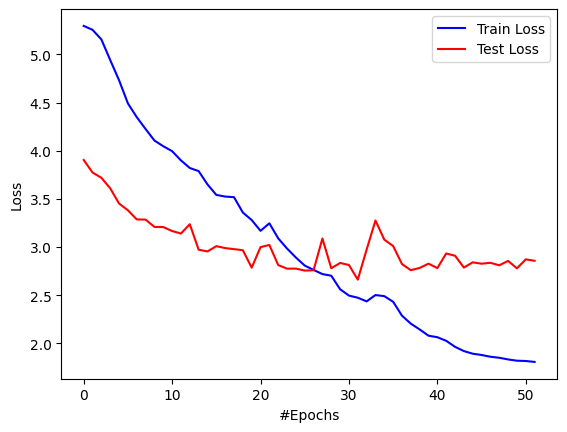

In [75]:
dropout_perc = 0.0
num_layers = 3
hidden_size = 30
network = LSTM_Model(num_layers, hidden_size, dropout_perc)
network = network.to(device)
print("Num. Parameters:", count_parameters(network))

optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25, cooldown=5, verbose=False)
loss_function = LSTM_MSELoss

batch_size = 800
num_epochs = 201
training_generator = torch.utils.data.DataLoader(trainHittersDataset, batch_size=batch_size, shuffle=True)
testing_generator = torch.utils.data.DataLoader(testHittersDataset, batch_size=batch_size, shuffle=False)

trainAndGraph(network, training_generator, testing_generator, loss_function, optimizer, scheduler, num_epochs, 10)

Sanity check

Make sure the model likes good players and doesn't like bad players

In [76]:
paddedHitterInput = torch.nn.utils.rnn.pad_sequence(hitterInput)
hitterLengths = torch.tensor([len(seq) for seq in hitterInput])
network.eval()
network.load_state_dict(torch.load("best_model.pt"))
network = network.to(device)

def GetPlayer(name, id):
    with torch.no_grad():
        for i, hitter in enumerate(hitters):
            if hitter[0] == id:
                idx = i
                break
            
        input = paddedHitterInput[:,idx,:].unsqueeze(0)

        output = savedModel(input.to(device), hitterLengths[idx].unsqueeze(0).to(device))

        print(name)
        torch.set_printoptions(precision=2, sci_mode=False)
        print(output.squeeze(0).squeeze(1).data)
        print(hitterOutput[idx][0])

In [77]:
GetPlayer("Michael Harrington", 518769)
GetPlayer("Mike Trout", 545361)
GetPlayer("Levi Michael", 605381)
GetPlayer("Bryce Harper", 547180)
GetPlayer("Mike Moustakas", 519058)
GetPlayer("Max Kepler", 596146)

Michael Harrington
tensor([ 0.13, -0.10,  0.02,  0.02,  0.01, -0.01, -0.02, -0.03, -0.04, -0.05,
        -0.05, -0.05, -0.04, -0.04, -0.04, -0.04], device='cuda:0')
tensor([0.])
Mike Trout
tensor([ 0.24,  3.83, 12.79, 15.58, 18.07, 19.28, 19.55, 19.60, 19.61, 19.61,
        19.61, 19.61, 19.61, 19.61, 19.61, 19.61, 19.61], device='cuda:0')
tensor([47.20])
Levi Michael
tensor([     0.24,      2.57,      0.14,      0.27,      0.30,      0.47,
             0.42,      0.40,      0.36,      0.37,      0.31,      0.27,
             0.18,      0.15,      0.12,      0.09,      0.06,      0.07,
             0.09,      0.12,      0.11,      0.09,      0.08,      0.06,
             0.03,      0.03,      0.02,      0.01,     -0.00,      0.00,
            -0.02,     -0.01,     -0.01,      0.01,      0.01,      0.02,
             0.02,      0.02,      0.03,      0.05,      0.05],
       device='cuda:0')
tensor([0.])
Bryce Harper
tensor([ 0.25,  6.10, 14.50, 17.07, 17.40, 17.41, 17.38, 17.40, 17.64, 